# Uncertainty quantification

In [1]:
import numpy as np
import openturns as ot

# Introduction

## Step A: problem specification

We study the deviation of a cantilever beam. An external force is applied to the free end of the beam.

The vertical deflection of the free end writes:

\begin{align}
    y =  \dfrac{F\,L^3}{3\,E\,I}
\end{align}

where:

* $E$ is the Young modulus ;
* $F$ is the load ;
* $L$ is the length of the beam ;
* $I$ is the moment of inertia.

## Step B: Quantifying uncertainty sources

The *variable of interest* is the deflection denoted as $y$.

$y$ can be estimated thanks to the *model* $\mathcal{M}$ being given the vector of *input variables* $\boldsymbol{x} = (E, F, L, I)$ which are assumed random.

## Step C: Numerical methods for estimating statistical quantities of interest

The output variable $Y = \mathcal{M}(\mathbf{X})$ is now random with unknown distribution. **Open TURNS** implements numerical methods for calculating statistical quantities of interest of that random variable. Two kinds will be investigated in this training:

* **Central dispersion summary statistics** such as the mean $\mu$ and variance $\sigma^2$ of the variable of interest $Y$ (**TP DJ 4**).

\begin{align}
    \mu & = \mathbb{E}\left[Y\right] \\
    \sigma^2 & = \mathbb{E}\left[(Y-\mu)^2\right]
\end{align}

* **Rare event probabilities** such as the probability of exceeding a threshold (**TP DJ4**).

\begin{align}
    \mathbb{P} \left[Y > 30~\text{cm}\right] = 1 - F_Y(30~\text{cm})
\end{align}

where $F_Y$ is the cumulative distribution function characterizing the probability distribution of $Y$.

# Focus on step B: Uncertainty Quantification (TP DJ3)

One seeks to define a model that best represents the distribution of the input random vector $\boldsymbol{X} = (E, F, L, I)$. 

One wants to assess the probability distribution of $\boldsymbol{X}$ described by its joint probability density function. The methods to be used depends on the available information. In this example, the available data are the folowing:

* A set of measurements of the Young modulus $E$ collected in a file; 
* Expert recommandations for the other input variables $F, L$ and $I$

**Open TURNS** provides probabilistic models together with the statistical tools for building them from the available data. 

**Open TURNS** provides functions to:

* fit probabilistic models to the available sample using either the *maximum likelihood principle* or the *method of moments*,

* validate these estimations with goodness-of-fit tests such as the Kolmogorov-Smirnov test (for continuous distributions) or the Chi-squared test (for discrete distributions) or visual tests such as the QQ-plot.

## Descriptive statistics of the available sample  
 
The CSV file `"sample_E.csv"` containing the list of data is imported in order to obtained a `Sample`, named here `sample_E`.

In [2]:
sample_E = ot.Sample.ImportFromCSVFile("sample_E.csv")
sample_E.setDescription(["Young Modulus"])
sample_E[0:5]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[Young Modulus] data=[[2.99532e+07],[2.86804e+07],[3.06412e+07],[3.2051e+07],[3.77857e+07]]

The `Sample` object is provided with methods for computing summary statistics of the sample.

In [3]:
print(" Size                  = %d" % sample_E.getSize())
print(" Mean                  = %.4g" % sample_E.computeMean()[0])
print(" Variance              = %.4g" % sample_E.computeCovariance()[0, 0])
print(" Standard deviation    = %.4g" % sample_E.computeStandardDeviation()[0, 0])
print(" Skewness              = %.4g" % sample_E.computeSkewness()[0])
print(" Kurtosis              = %.4g" % sample_E.computeKurtosis()[0])
print(" Median                = %.4g" % sample_E.computeQuantile(0.5)[0])
print(
    " Interquartile         = [%.4g, %.4g]"
    % (sample_E.computeQuantile(0.25)[0], sample_E.computeQuantile(0.75)[0])
)
print(
    " Range                 = [%.4g, %.4g]"
    % (sample_E.getMin()[0], sample_E.getMax()[0])
)

 Size                  = 229
 Mean                  = 3.387e+07
 Variance              = 2.066e+13
 Standard deviation    = 4.545e+06
 Skewness              = 0.7994
 Kurtosis              = 2.89
 Median                = 3.309e+07
 Interquartile         = [2.987e+07, 3.69e+07]
 Range                 = [2.801e+07, 4.812e+07]


Open TURNS has also methods to compute empirical approximations of the PDF and CDF.

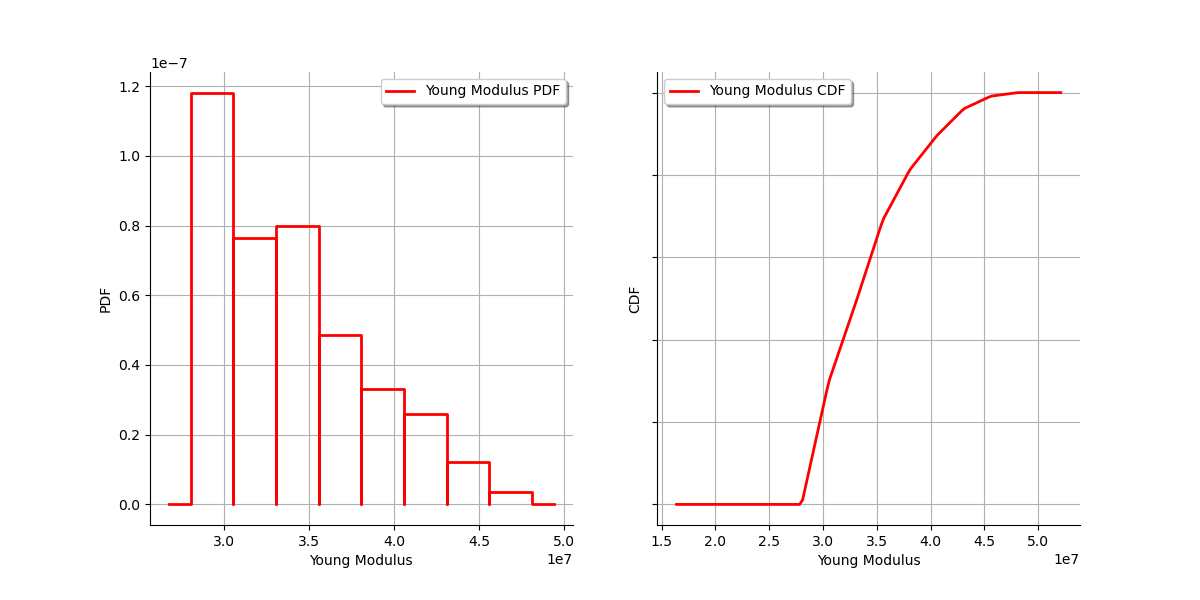

In [4]:
# Histogram
histogram = ot.HistogramFactory().build(sample_E)
grid = ot.GridLayout(1, 2)
grid.setGraph(0, 0, histogram.drawPDF())
grid.setGraph(0, 1, histogram.drawCDF())
grid

# Fitting probability distributions

The objective is to estimate the parameters of a **supposed parametric distribution** from the sample.

## Parametric models

**Open TURNS** implements the main probability distributions (Beta, Normal, etc.).

In [5]:
distribution = ot.Beta(2.0, 4.0, -1.0, 1.0)

In [6]:
mean = distribution.getMean()
print("mean_value = %s" % mean[0])
print("pdf_value_at_mean = %s" % distribution.computePDF(mean))
print("cdf_value_at_mean = %s" % distribution.computeCDF(mean))
distribution.getSample(10)

mean_value = -0.33333333333333337
pdf_value_at_mean = 0.9876543209876545
cdf_value_at_mean = 0.5390946502057613


class=Sample name=Beta implementation=class=SampleImplementation name=Beta size=10 dimension=1 description=[X0] data=[[-0.176569],[-0.732085],[-0.49784],[0.404231],[-0.833393],[-0.0566072],[-0.46977],[0.285917],[-0.101189],[-0.484457]]

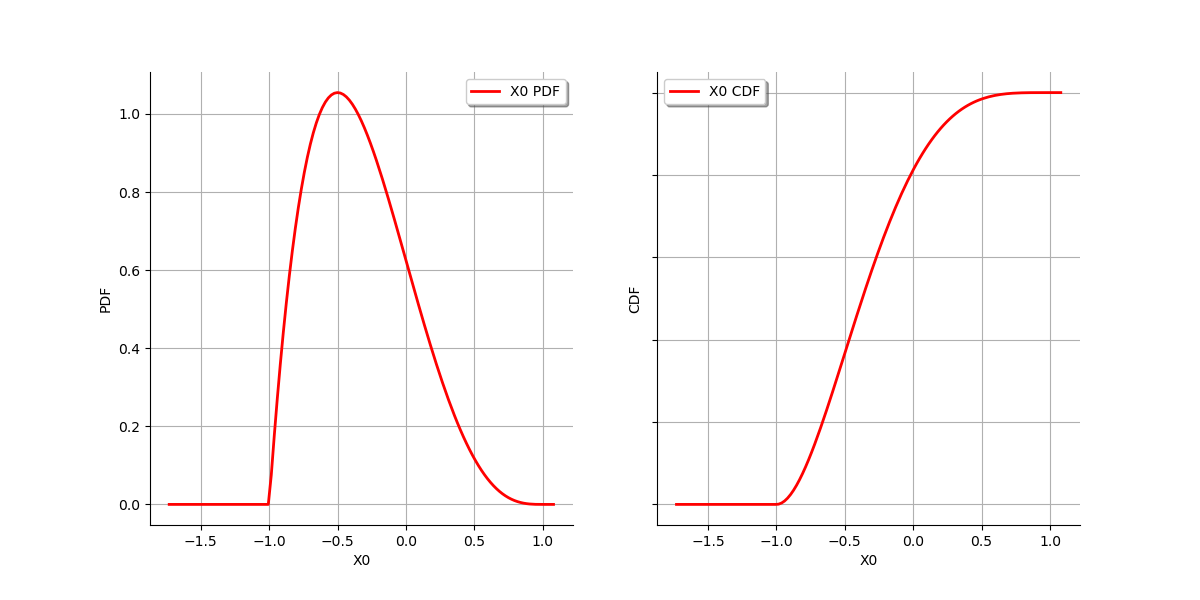

In [7]:
grid = ot.GridLayout(1, 2)
grid.setGraph(0, 0, distribution.drawPDF())
grid.setGraph(0, 1, distribution.drawCDF())
grid

## Fitting a parametric model

**Open TURNS** implements estimators (named "factories") for each parametric model. Each `Factory` selects the best-suited estimation technique (either the Maximum Likelihood method, the method of moments or other distribution-specific methods).

In [8]:
fitted_E = ot.BetaFactory().build(sample_E)

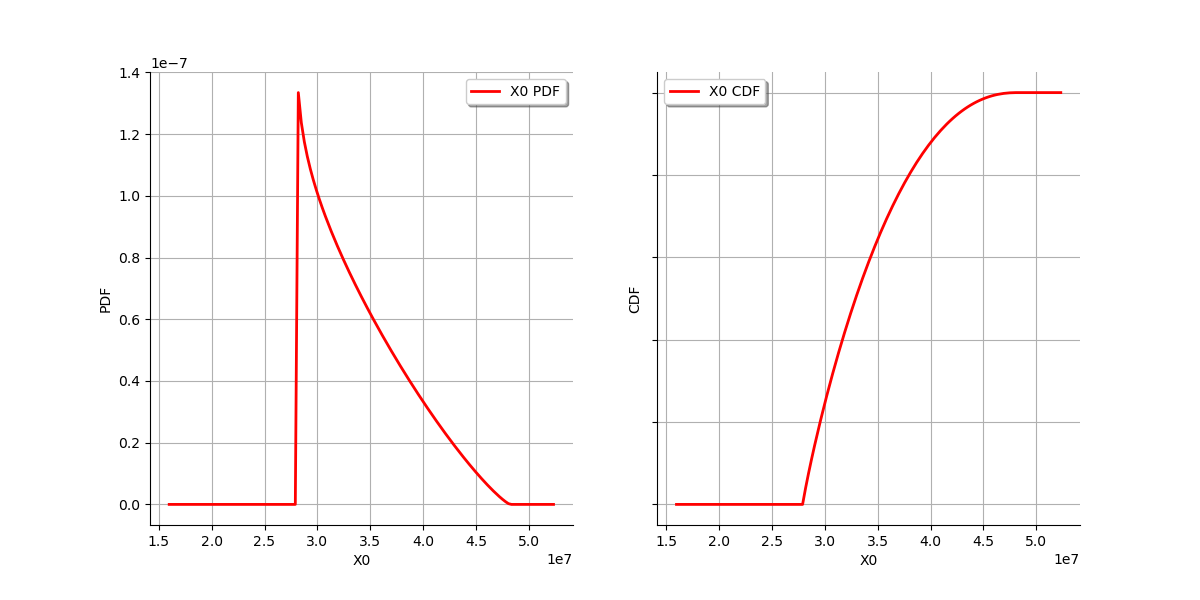

In [9]:
grid = ot.GridLayout(1, 2)
grid.setGraph(0, 0, fitted_E.drawPDF())
grid.setGraph(0, 1, fitted_E.drawCDF())
grid

In [10]:
print(fitted_E.getParametersCollection())

[[alpha : 0.91834, beta : 2.21034, a : 2.79215e+07, b : 4.82022e+07]]


## Goodness-of-fit tests

Statistical tools enables the verification of the choice of a distribution, given a set of data. Among these tests are:
- parametric tests,
- visual tests.

We introduce here one test of each type:
- the Kolmogorov-Smirnov test,
- the QQ-plot.

Let's test if the sample `sample_E` is distributed according to the given distribution (Null Hypothesis). 

### Kolmogorov-Smirnov test

They are tested with the method `ot.FittingTest.Kolmogorov`.

It takes as argument the sample `sample_E`, the tested distribution `fitted_E` and the **specificity** of the test. A $0.95$ specifity correponds to an admitted risk of type I error $\alpha = 5 \%$.

`ot.FittingTest.Kolmogorov` returns a `TestResult` object.

In [11]:
kstest_result = ot.FittingTest.Kolmogorov(sample_E, fitted_E, 1.0 - 0.05)
print(kstest_result.getDescription()[0])
print("p-value = %.2e" % kstest_result.getPValue())
if kstest_result.getBinaryQualityMeasure():
    print(
        "KS test cannot reject the null hypothesis with significance level %.2f."
        % kstest_result.getThreshold()
    )
else:
    print(
        "KS test rejects the null hypothesis with significance level %.2f."
        % kstest_result.getThreshold()
    )

Beta(alpha = 0.91834, beta = 2.21034, a = 2.79215e+07, b = 4.82022e+07) vs sample sample_E.csv
p-value = 9.53e-01
KS test cannot reject the null hypothesis with significance level 0.95.


### QQ-plot

The quantile-quantile plot is a visual goodness-of-fit test. For each point of the sample used in the graph, **Open TURNS** evaluates its empirical quantile. 

The empirical quantile is plotted versus corresponding quantile from the fitted distribution.

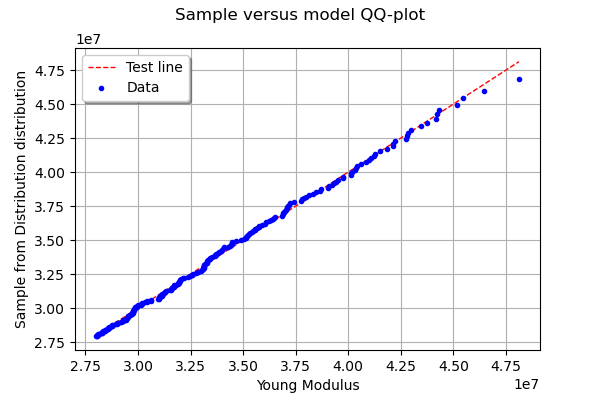

In [12]:
QQ_plot = ot.VisualTest_DrawQQplot(sample_E, fitted_E)
QQ_plot.setXTitle(sample_E.getDescription()[0])
QQ_plot.setYTitle("Sample from %s distribution" % fitted_E.getClassName())
QQ_plot

## Non-parametric fitting

The *kernel smoothing* of the probability density function of a distribution is obtained thanks to the following formula in dimension 1:

$f_{KS}(x) = \dfrac{1}{N\,h} \sum \limits_{i=1}^N K \left( \dfrac{x-x^{(i)}}{h} \right)$

where $h$ is the bandwidth and $K$ is the univariate kernel satisfying $\int K(x) =1$.

The **Open TURNS** implementation of this technique yields a complete distribution (equivalent to the other parametric distributions).

In [13]:
kernel = ot.Normal()
kernel_smoothing = ot.KernelSmoothing(kernel)
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
smoothed_E = kernel_smoothing.build(sample_E, bandwidth)

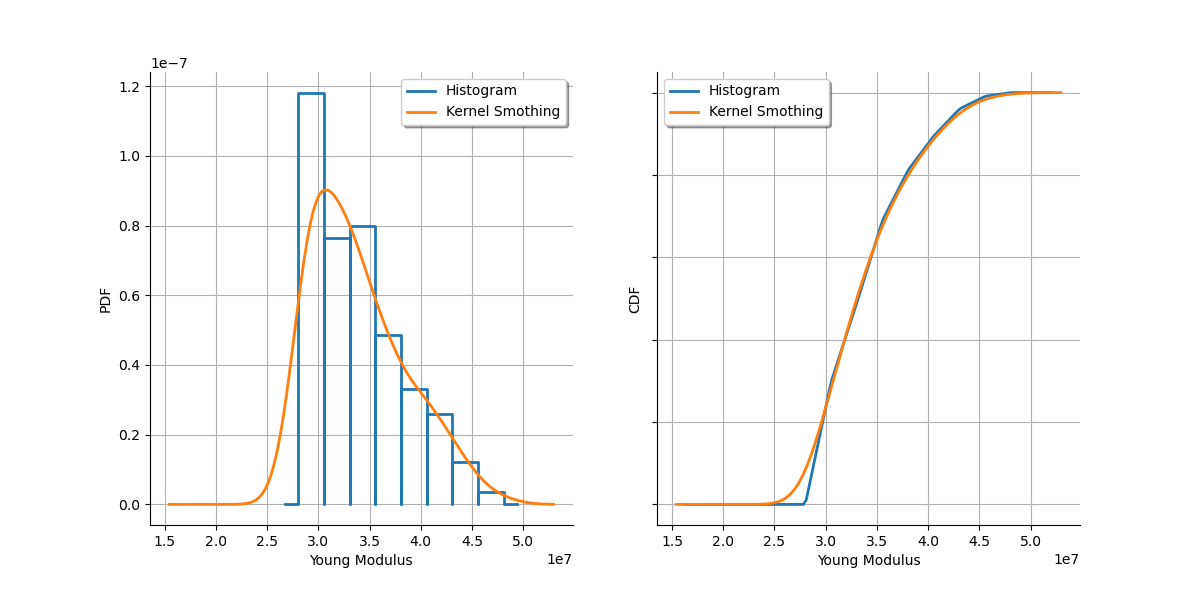

In [14]:
histogram = ot.HistogramFactory().build(sample_E)
# Graph 1: PDF
hist_E_pdf = histogram.drawPDF()
hist_E_pdf.setLegends(["Histogram"])
graph = smoothed_E.drawPDF()
graph.setLegends(["Kernel Smothing"])
hist_E_pdf.add(graph)
hist_E_pdf.setColors(ot.Drawable_BuildDefaultPalette(2))

# Graph 2: CDF
hist_E_cdf = histogram.drawCDF()
hist_E_cdf.setLegends(["Histogram"])
graph = smoothed_E.drawCDF()
graph.setLegends(["Kernel Smothing"])
hist_E_cdf.add(graph)
hist_E_cdf.setColors(ot.Drawable_BuildDefaultPalette(2))

#
grid = ot.GridLayout(1, 2)
grid.setGraph(0, 0, hist_E_pdf)
grid.setGraph(0, 1, hist_E_cdf)
grid

## Comparison of the proposed distributions

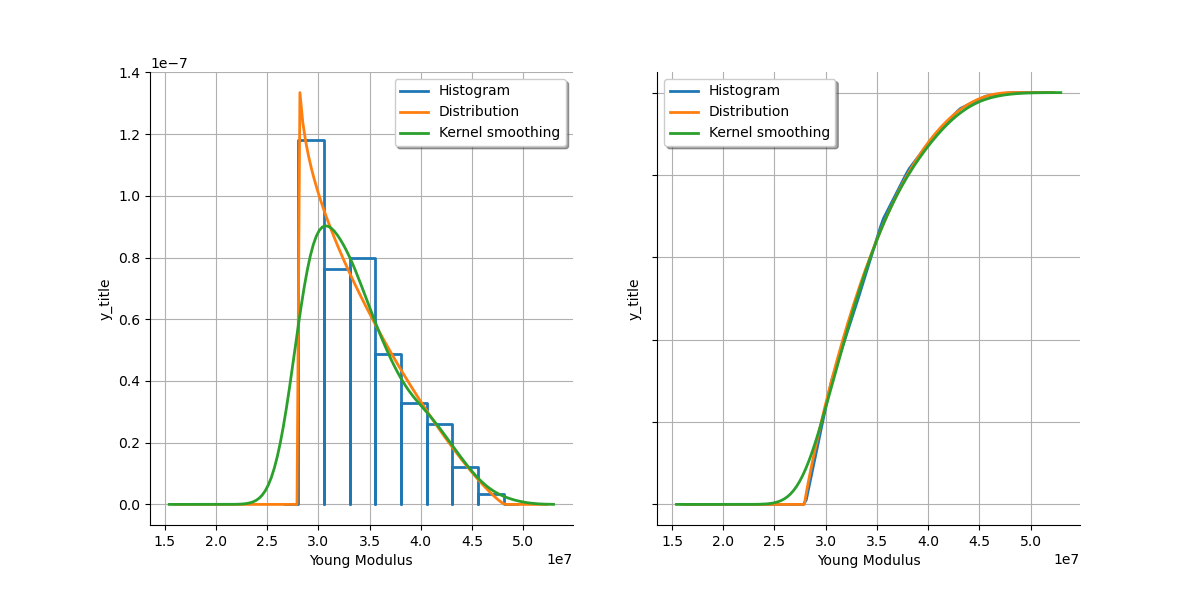

In [15]:
# Graph 1: PDF
histogram = ot.HistogramFactory().build(sample_E)
hist_pdf = histogram.drawPDF().getDrawable(0)
hist_pdf.setLegend("Histogram")

fitted_pdf = fitted_E.drawPDF().getDrawable(0)
fitted_pdf.setLegend(fitted_E.getClassName())

smoothed_pdf = smoothed_E.drawPDF().getDrawable(0)
smoothed_pdf.setLegend("Kernel smoothing")
#
graph_pdf = ot.Graph(
    "Proba_density functions", sample_E.getDescription()[0], "y_title", True, "topright"
)
graph_pdf.add([hist_pdf, fitted_pdf, smoothed_pdf])
graph_pdf.setColors(ot.Drawable_BuildDefaultPalette(3))
# Graph 2: CDF
histo_CDF = histogram.drawCDF().getDrawable(0)
histo_CDF.setLegend("Histogram")

fitted_cdf = fitted_E.drawCDF().getDrawable(0)
fitted_cdf.setLegend(fitted_E.getClassName())

smoothed_cdf = smoothed_E.drawCDF().getDrawable(0)
smoothed_cdf.setLegend("Kernel smoothing")

graph_cdf = ot.Graph("CDF", sample_E.getDescription()[0], "y_title", True, "topleft")
graph_cdf.add([histo_CDF, fitted_cdf, smoothed_cdf])
graph_cdf.setColors(ot.Drawable_BuildDefaultPalette(3))
#
grid = ot.GridLayout(1, 2)
grid.setGraph(0, 0, graph_pdf)
grid.setGraph(0, 1, graph_cdf)
grid

# Definition of the input parameters: probabilistic model

In [16]:
dim = 4  # number of parameters

##Distributions

# Young modulus E : kernel smoothed distribution
E = smoothed_E

# loading F: lognormal
F = ot.LogNormal()
F.setParameter(ot.LogNormalMuSigma()([30000.0, 9000.0, 15000.0]))
F.setDescription(["Load"])

# Length L: uniform
L = ot.Uniform(250.0, 260.0)
L.setDescription(["Length"])

# Inertia I: beta
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(["Inertia"])

# Creation of a copula : Normal copula of dimension 3 from Spearman rank correlation matrix
SR_cor = ot.CorrelationMatrix(dim)
SR_cor[2, 3] = -0.2

copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))


# Create the distribution
X_distribution = ot.ComposedDistribution([E, F, L, I], copula)
X_distribution.setDescription(("E", "F", "L", "I"))

X_random_vector = ot.RandomVector(X_distribution)

4. Definition of the physical modal
--------------------------------

In [17]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

Y_random_vector = ot.CompositeRandomVector(model, X_random_vector)

In [18]:
N = 1000

In [19]:
ot.RandomGenerator.SetSeed(0)

In [20]:
Y_sample = Y_random_vector.getSample(N)

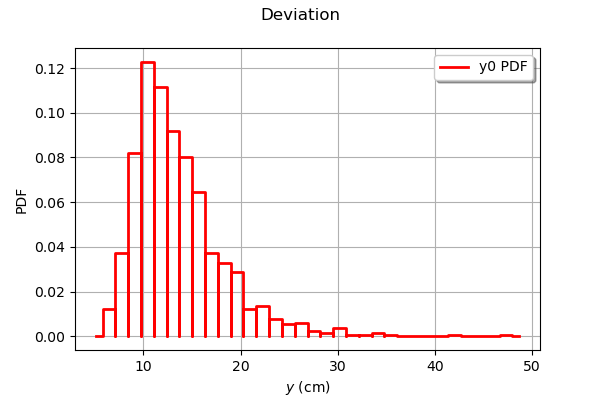

In [21]:
Y_mean_sample = Y_sample.computeMean()[0]
Y_std_sample = np.sqrt(Y_sample.computeCovariance()[0, 0])
y_min = Y_mean_sample - 4 * Y_std_sample
y_max = Y_mean_sample + 4 * Y_std_sample

sample_Y_hist = ot.HistogramFactory().build(Y_sample).drawPDF()
sample_Y_hist.setXTitle("$y$ (cm)")
sample_Y_hist.setTitle("Deviation")
sample_Y_hist

In [22]:
Y_mean_sample

13.563872751798254

5. Representation of 2 marginals
----------------------------------

## $E$ Young modulus

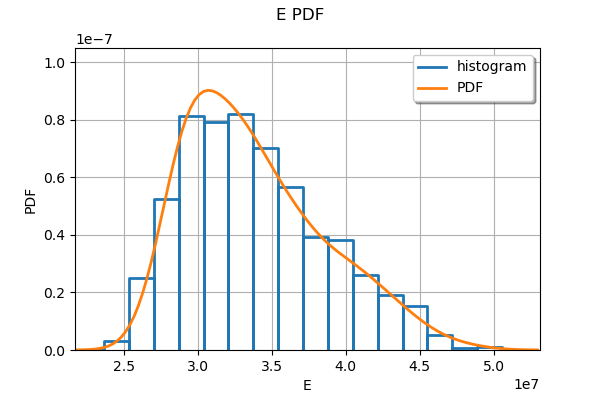

In [23]:
X_variable = X_distribution.getMarginal(0)
X_sample = X_variable.getSample(1000)

bounding_box = ot.Interval(
    [X_variable.computeQuantile(1e-5)[0], 0.0],
    [X_variable.computeQuantile(1.0 - 1e-5)[0], 1.05e-7],
)

X_sample_hist = ot.HistogramFactory().build(X_sample).drawPDF()
X_sample_hist.setBoundingBox(bounding_box)
X_sample_hist.setLegends(["histogram"])
X_sample_hist.setXTitle(X_variable.getDescription()[0])
X_PDF_draw = X_variable.drawPDF()
X_PDF_draw.setLegends(["PDF"])
X_PDF_draw.setBoundingBox(bounding_box)
X_sample_hist.add(X_PDF_draw)
X_sample_hist.setColors(ot.Drawable_BuildDefaultPalette(2))
X_sample_hist

## $F$: Loading

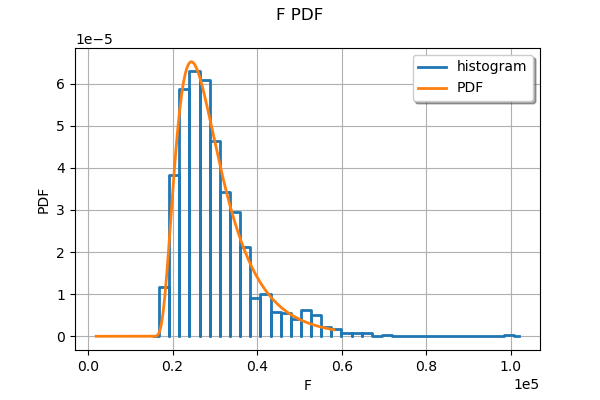

In [24]:
X_variable = X_distribution.getMarginal(1)
X_sample = X_variable.getSample(1000)

bounding_box = ot.Interval(
    [X_variable.computeQuantile(1e-2)[0], 0.0],
    [X_variable.computeQuantile(1.0 - 1e-2)[0], 0.000075],
)


X_sample_hist = ot.HistogramFactory().build(X_sample).drawPDF()
X_sample_hist.setLegends(["histogram"])
X_sample_hist.setXTitle(X_variable.getDescription()[0])

X_PDF_draw = X_variable.drawPDF()
X_PDF_draw.setLegends(["PDF"])
X_PDF_draw.setBoundingBox(bounding_box)
X_sample_hist.add(X_PDF_draw)
X_sample_hist.setColors(ot.Drawable_BuildDefaultPalette(2))
X_sample_hist

### Représentation en 2D

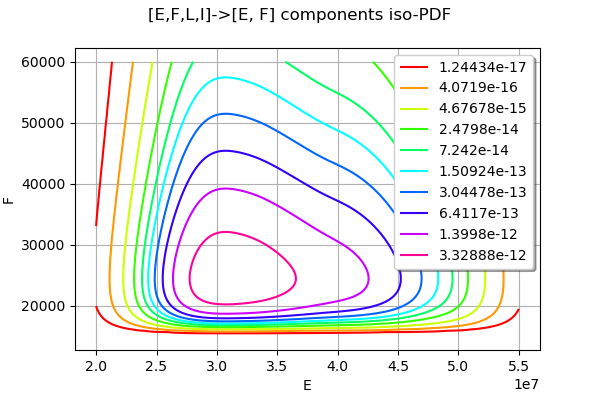

In [25]:
marginal1 = 0  # E
marginal2 = 1  # F
graph = X_distribution.drawMarginal2DPDF(
    marginal1, marginal2, [2e7, 1.5e4], [5.5e7, 60000], [200, 200]
)
graph